In [5]:
import logging
import os
from pathlib import Path

import cm1.input.sounding
import pandas as pd
import xarray
from cm1.run import PBS, CM1Run
from cm1.utils import animate_cm1out_nc, skewt
from metpy.units import units

In [6]:
# Path to the CM1 repository
cm1_path = Path(os.getenv("SCRATCH")) / "cm1"

In [7]:
testcase = "supercell"
run_dir = cm1_path / f"run_{testcase}"

pbs_config = PBS(
    name=testcase,
    account=os.getenv("PBS_ACCOUNT"),
    walltime="01:00:00",
    nodes=1,
    run_dir=run_dir,
    executable_path=cm1_path / "run/cm1.exe",
)

# If the testcase is 1 or 2-D use cm1 compiled for single processor
run_serial = testcase.startswith("scm_") or testcase == "nh_mountain_waves"
if run_serial:
    pbs_config.executable_path = cm1_path / "run/cm1.single.gnu.exe"

In [8]:
cm1_run = CM1Run(cm1_path=cm1_path, pbs_config=pbs_config)
# Modify values in namelist
namelist = cm1_run.namelist
# Combine output in one netCDF file.
namelist["param9"]["output_format"] = 2
namelist["param9"]["output_filetype"] = 1

if testcase in ["supercell"]:
    valid_time = pd.to_datetime("20240525")
    lon = -95 * units.degree_E
    lat = 33 * units.degree_N
    # Run with temperature, wind from "input_sounding".
    namelist["param2"]["isnd"] = 7
    ofile = run_dir / "input_sounding"
    if os.path.exists(ofile):
        logging.warning(f"{ofile} already exists")
    else:
        if os.path.exists("/glade/campaign") or os.path.exists("/campaign"):
            input_sounding_ds = cm1.input.sounding.era5_model_level(valid_time, lon=lon, lat=lat)
        else:
            input_sounding_ds = cm1.input.sounding.era5_aws(valid_time, lon=lon, lat=lat)
        with open(ofile, "w") as f:
            f.write(cm1.input.sounding.to_txt(input_sounding_ds))
            logging.warning(ofile)

if run_serial:
    cm1_run.run_serial(background=False)
else:
    cm1_run.submit_job()
print(cm1_run.readme)

7827697.desched1

  Idealized supercell thunderstorm simulation, following 
  Weisman and Rotunno (2000, JAS, pg 1452). 

  Configuration is the 1/4-Circle hodograph case. 




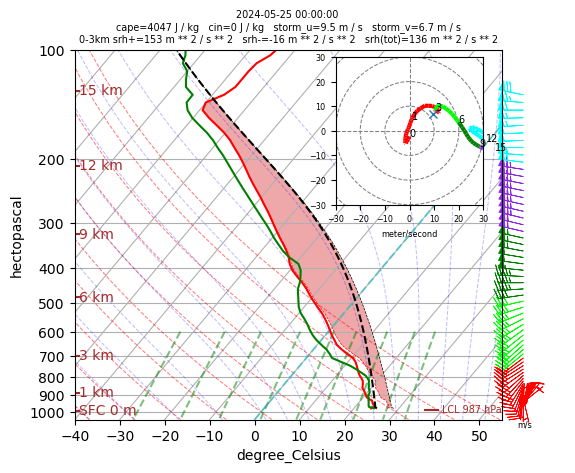

In [9]:
ifile = run_dir / "input_sounding"
if os.path.exists(ifile):
    # sounding from text has no `time` so assign it. It will show in title.
    skewt(cm1.input.sounding.read_from_txt(ifile).assign(time=valid_time))

In [11]:
# Open NetCDF file
output_ds = xarray.open_dataset(run_dir / "cm1out.nc")

animate_cm1out_nc(output_ds, "dbz", height=0.1, dim="zh", vmin=-16, vmax=60, cmap="gist_ncar")

In [ ]:
help(CM1Run)